In [2]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for imutils, since package 'wheel' is not installed.
  Running setup.py install for imutils: started
  Running setup.py install for imutils: finished with status 'done'


You should consider upgrading via the 'C:\Users\loren\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import os
from glob import glob
import re
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import math


ModuleNotFoundError: No module named 'sklearn'

In [4]:
def save_frames(video_path, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Read the first frame
    success, frame = cap.read()
    count = 0

    # Loop through the video frames
    while success:
        # Save the frame as an image
        frame_path = os.path.join(output_folder, f"frame_{count}.jpg")
        cv2.imwrite(frame_path, frame)

        # Read the next frame
        success, frame = cap.read()
        count += 1

    # Release the video capture object
    cap.release()

# Backgroud subtraction with frame difference

We simply perform frame difference and threshold to detect moving frames: the problem is that the camera also moves and we need to compensate the motion

In [5]:
# METODO 1
# Initialize video capture
cap = cv2.VideoCapture('nadal1.mp4')
# Read the first frame and convert to grayscale
ret, prev = cap.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
kernel = np.ones((5,5),np.uint8)


while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate the absolute difference between the current frame and the previous frame
    frame_diff = cv2.absdiff(gray, prev)

    # Apply a binary threshold to the difference image
    ret, thresh = cv2.threshold(frame_diff,  70,  250, cv2.THRESH_BINARY)
    res_2 = cv2.bitwise_and(frame,frame, mask=thresh)
    #opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    
    # frame_HSV = cv2.cvtColor(res_2, cv2.COLOR_BGR2HSV)
    # frame_threshold = cv2.inRange(frame_HSV, lower,upper)
    #thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    # Display the original frame and the thresholded image
    #cv2.imshow('Original', frame)
    cv2.imshow('Foreground Mask', thresh)

    # Update the background frame
    prev = gray.copy()

    # Break the loop if 'q' is pressed
    if cv2.waitKey(5) &  0xFF == ord('q'):
        break

# Release the video capture and destroy all windows
cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [4]:
def get_mask(frame1, frame2, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            kernel - (NxN) array for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """

    frame_diff = cv2.subtract(frame2, frame1)

    # blur the frame difference
    frame_diff = cv2.medianBlur(frame_diff, 3)
    
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV, 11, 3)

    mask = cv2.medianBlur(mask, 3)

    # morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask




In [5]:
# compute motion mask
cap = cv2.VideoCapture('nadal1.mp4')

ret, prev = cap.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
kernel = np.ones((5,5),np.uint8)


while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask = get_mask(prev, gray, kernel)
    cv2.imshow('Foreground Mask', mask)

    # Update the background frame
    prev = gray.copy()

    # Break the loop if 'q' is pressed
    if cv2.waitKey(5) &  0xFF == ord('q'):
        break

# Release the video capture and destroy all windows
cap.release()
cv2.destroyAllWindows()



In [9]:
save_frames('nadal1.mp4', 'frames1')

# Motion detection with camera movement compensation
- Compute key points on frame 1
- Compute Sparse Optical Flow from frame 1 to frame 2
- Perform Motion Compensation to Obtain Compensated key points


Optical Flow describes the motion of a pixel from one frame to next in an image sequence. Sparse Optical Flow computes this motion for notable features such as corners, while Dense Optical Flow computes the motion for all pixels.

Camera Motion Compensation allows use to account for camera motion when detecting moving objects, it is the transformation from the previous frame to the current frame. The Sparse Optical Flow will help us find this transformation. Steps 1–3 are outlined below in a bit more detail:

- Compute key points on frame 1 by detecting strong features
- Use Sparse Optical Flow to match key points to frame 2
- Perform Motion Compensation on key points from frame 1
- Use arrays of previous and current key points to compute a transformation from frame 1 to frame 2
- Perform transformation on key points from frame 1

We can accomplish step 1 with corner detection or any feature detection algorithm, and step 2 is performed with Sparse Optical Flow. The matching result of step 2 provides the new locations of the key points due to camera motion. (i.e. same pixels at new image coordinates). The deltas between the key points of frame 1 and 2 constitute the flow vectors.
source: https://python.plainenglish.io/unsupervised-motion-detection-8b523c53c49b

In [127]:
def motion_comp(prev_frame, curr_frame, num_points=500, points_to_use=500, transform_type='affine'):
    """ Obtains new warped frame1 to account for camera (ego) motion
        Inputs:
            prev_frame - first image frame
            curr_frame - second sequential image frame
            num_points - number of feature points to obtain from the images
            points_to_use - number of point to use for motion translation estimation 
            transform_type - type of transform to use: either 'affine' or 'homography'
        Outputs:
            A - estimated motion translation matrix or homography matrix
            prev_points - feature points obtained on previous image
            curr_points - feature points obtaine on current image
        """
    transform_type = transform_type.lower()
    assert(transform_type in ['affine', 'homography'])

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)

    # get features for first frame
    corners = cv2.goodFeaturesToTrack(prev_gray, num_points, qualityLevel=0.01, minDistance=10)

    # get matching features in next frame with Sparse Optical Flow Estimation
    matched_corners, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, corners, None)

    # reformat previous and current corner points
    prev_points = corners[status==1]
    curr_points = matched_corners[status==1]

    # sub sample number of points so we don't overfit
    if points_to_use > prev_points.shape[0]:
        points_to_use = prev_points.shape[0]

    index = np.random.choice(prev_points.shape[0], size=points_to_use, replace=False)
    prev_points_used = prev_points[index]
    curr_points_used = curr_points[index]

    # find transformation matrix from frame 1 to frame 2
    if transform_type == 'affine':
        A, _ = cv2.estimateAffine2D(prev_points_used, curr_points_used, method=cv2.RANSAC)
    elif transform_type == 'homography':
        A, _ = cv2.findHomography(prev_points_used, curr_points_used)

    return A, prev_points, curr_points

In [128]:
frame1= cv2.imread('Dataset/game1/Clip2/0036.jpg')
frame2= cv2.imread('Dataset/game1/Clip2/0037.jpg')

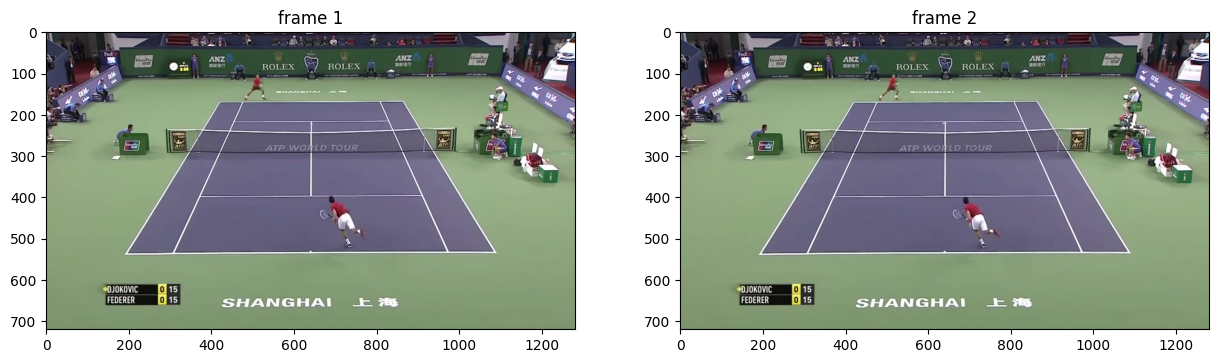

In [129]:
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

In [9]:
A, prev_points, curr_points = motion_comp(frame1, frame2, num_points=10000, points_to_use=10000, transform_type='affine')
transformed1 = cv2.warpAffine(frame1, A, dsize=(frame1.shape[:2][::-1])) # affine transform

# Camera Motion Compensation on frame 1 (for reference)
# transformed1 = cv2.warpAffine(frame1, A, dsize=(frame1.shape[:2][::-1])) # affine transform

# Camera Motion Compensation on Key Points
A = np.vstack((A, np.zeros((3,)))) # convert 2x3 affine to 3x3 matrix 
compensated_points = np.hstack((prev_points, np.ones((len(prev_points), 1)))) @ A.T 

compensated_points = compensated_points[:, :2]
print(f" Prev Key Points: {np.round(prev_points[100], 2)} \n",
      f"Compensated Key Points: {np.round(compensated_points[100], 2)} \n",
      f"Current Key Points: {np.round(curr_points[100], 2)}")

 Prev Key Points: [321. 275.] 
 Compensated Key Points: [320.99 275.45] 
 Current Key Points: [320.99 275.5 ]


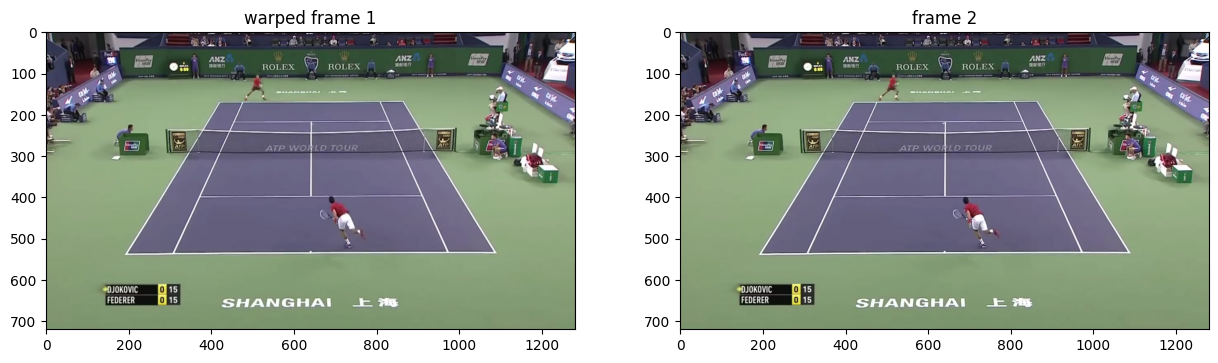

In [10]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(transformed1)
ax[0].set_title("warped frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

In [11]:
og_delta = cv2.subtract(frame2, frame1)
comped_delta = cv2.subtract(frame2, transformed1)

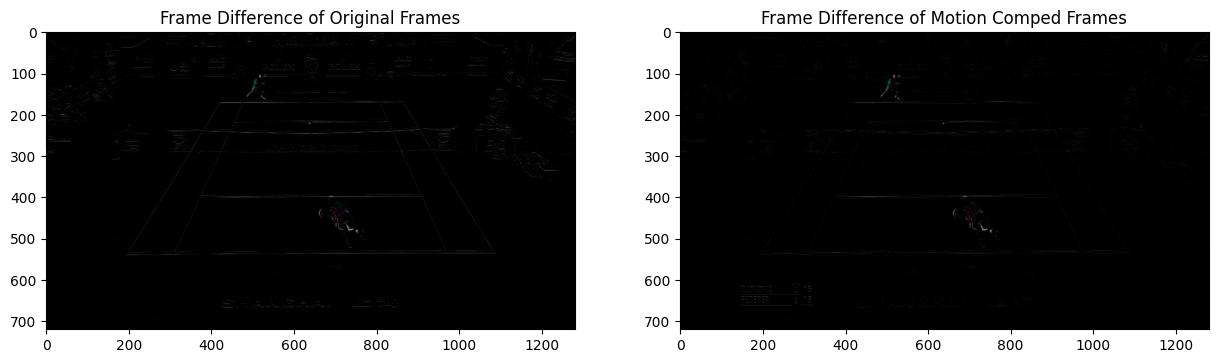

In [12]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(og_delta)
ax[0].set_title("Frame Difference of Original Frames")
ax[1].imshow(comped_delta)
ax[1].set_title("Frame Difference of Motion Comped Frames");

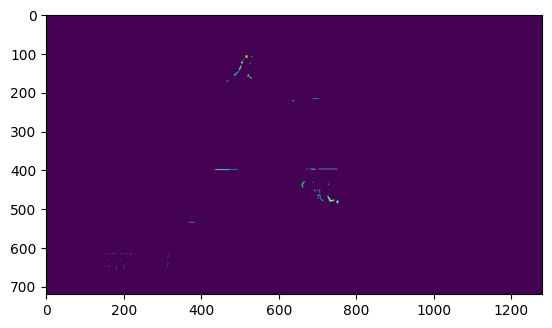

In [13]:
plt.imshow(cv2.cvtColor(comped_delta, cv2.COLOR_RGB2GRAY) > 50)


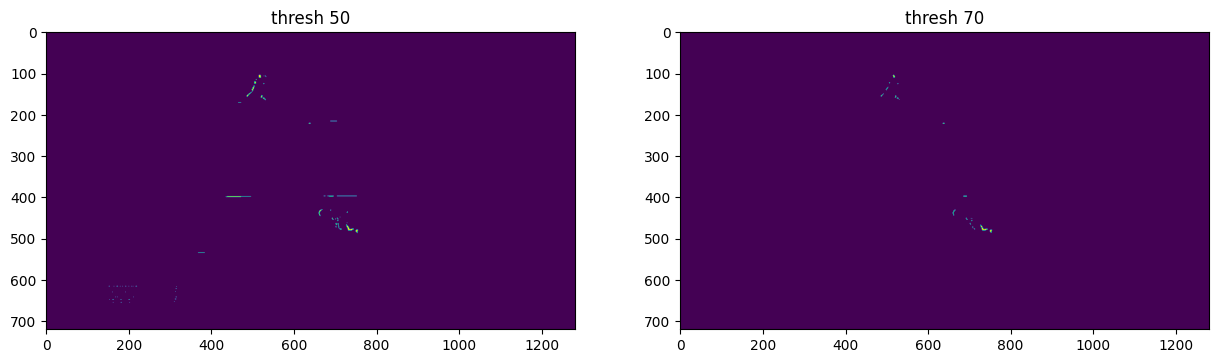

In [14]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(cv2.cvtColor(comped_delta, cv2.COLOR_RGB2GRAY) > 50)
ax[0].set_title("thresh 50")
ax[1].imshow(cv2.cvtColor(comped_delta, cv2.COLOR_RGB2GRAY) > 70)
ax[1].set_title("thresh 70");

## Detect motion with connected components

In [130]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
def motion_pipeline(path):
    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])


    first_frame_path = os.path.join(path, frame_files[0])
    prev = cv2.imread(first_frame_path)

    for frame_file in frame_files[1:]:
        frame_path = os.path.join(path, frame_file)
        frame = cv2.imread(frame_path)
        A, prev_points, curr_points = motion_comp(prev, frame, num_points=10000, points_to_use=10000, transform_type='affine')
        transformed1 = cv2.warpAffine(prev, A, dsize=(prev.shape[:2][::-1]))
        comped_delta = cv2.subtract(frame, transformed1)
        comped_delta = cv2.cvtColor(comped_delta, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(comped_delta,  70,  230, cv2.THRESH_BINARY)
        dilated = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8, ltype=cv2.CV_32S)

        # Process connected components to group nearby small components
        grouped_stats = []
        output = frame.copy()
        for i in range(1, numLabels):  # Skip the first label (background)
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            
            
            (cX, cY) = centroids[i]
            cX = int(cX)
            cY = int(cY)
            #cv2.circle(output, (cX, cY),  4, (0,  0,  255), -1)
            major_axis_length = max(w, h)
            minor_axis_length = min(w, h)
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= 2 and area <= 50 and major_axis_length>=2 and major_axis_length<=15:  # Define a threshold area for small components
                cv2.rectangle(output, (x, y), (x + w, y + h), (0,  255,  0),  2)
                #cv2.circle(output, (cX, cY),  4, (0,  0,  255), -1)
            # if w * h < 1000:  # Define a threshold area for small components
            #     # Check if this component is close to others
            #     close_components = []
            #     for j in range(1, numLabels):
            #         if i != j:
            #             x2 = stats[j, cv2.CC_STAT_LEFT]
            #             y2 = stats[j, cv2.CC_STAT_TOP]
            #             dist = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
            #             if dist < 60:  # Define a threshold distance for closeness
            #                 close_components.append(j)

            #     # If there are 5 or more close components, group them together
            #     if len(close_components) >= 4:
            #         close_components.append(i)  # Include the current component
            #         grouped_stats.append(close_components)

        # Draw blue bounding box around grouped components
        
        # for group in grouped_stats:
        #     min_x = min([stats[i, cv2.CC_STAT_LEFT] for i in group])
        #     min_y = min([stats[i, cv2.CC_STAT_TOP] for i in group])
        #     max_x = max([stats[i, cv2.CC_STAT_LEFT] + stats[i, cv2.CC_STAT_WIDTH] for i in group])
        #     max_y = max([stats[i, cv2.CC_STAT_TOP] + stats[i, cv2.CC_STAT_HEIGHT] for i in group])

        #     cv2.rectangle(output, (min_x - 5, min_y - 5), (max_x + 5, max_y + 5), (255, 0, 0), 2)

        cv2.imshow("Output", output)
        prev = frame.copy()

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    #cap.release()
    cv2.destroyAllWindows()


In [119]:
def calculate_IOU(bb1, bb2):
    x1_tl, y1_tl, w1, h1, cx1, cy1 = bb1
    x2_tl, y2_tl, w2, h2, cx1, cy1 = bb2

    x1_br, y1_br = x1_tl + w1, y1_tl + h1
    x2_br, y2_br = x2_tl + w2, y2_tl + h2

    x_overlap = max(0, min(x1_br, x2_br) - max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br) - max(y1_tl, y2_tl))

    intersection_area = x_overlap * y_overlap
    bb1_area = w1 * h1
    bb2_area = w2 * h2
    union_area = bb1_area + bb2_area - intersection_area

    return intersection_area / union_area

In [120]:
def return_connected_components(prev, current):
    connected_components = []
    A, prev_points, curr_points = motion_comp(prev, current, num_points=10000, points_to_use=10000, transform_type='affine')
    transformed1 = cv2.warpAffine(prev, A, dsize=(prev.shape[:2][::-1]))
    comped_delta = cv2.subtract(current, transformed1)
    comped_delta = cv2.cvtColor(comped_delta, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(comped_delta,  70,  230, cv2.THRESH_BINARY)
    dilated = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8, ltype=cv2.CV_32S)

    # Process connected components to group nearby small components
    grouped_stats = []
    #output = frame.copy()
    for i in range(1, numLabels):  # Skip the first label (background)
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
            
            
        (cX, cY) = centroids[i]
        cX = int(cX)
        cY = int(cY)
        major_axis_length = max(w, h)
        minor_axis_length = min(w, h)
        
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= 2 and area <= 50 and major_axis_length>=2 and major_axis_length<=15:  # Define a threshold area for small components
            connected_components.append((x, y, w, h, cX, cY))
    return connected_components


In [123]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))


def motion_pipeline(path):
    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])
    # data structure to store interceptions of BB from frame t-1
    prev_frame_bbs = []
    # data structure to store interceptions of BB from frame t-2
    prev_frame_bbs2 = []
    # dict that stores the trajectory of the objects
    trajectories = {}

    first_frame_path = os.path.join(path, frame_files[0])
    second_frame_path = os.path.join(path, frame_files[1])
    third_frame_path = os.path.join(path, frame_files[2])
    frame_1 = cv2.imread(first_frame_path)
    frame_2 = cv2.imread(second_frame_path)
    frame_3 = cv2.imread(third_frame_path)
    conn_comp12 = return_connected_components(frame_1, frame_2)
    conn_comp23 = return_connected_components(frame_2, frame_3)
    
    prev_frame_bbs = conn_comp12
    prev_frame_bbs2 = conn_comp23  
    # the objects in prev_frame_bbs are all new so add all to the trajectory
    for i, bb in enumerate(prev_frame_bbs):
        trajectories[i] = {
            'start_frame': 1,
            'coordinates': [(1, bb)]
        }
    #for every frame in prev_frame_bbs2 check if there is an interception with frames in trajectories
    for i, bb in enumerate(prev_frame_bbs2):
        max_iou = 0
        max_iou_index = 0
        for j, bb2 in enumerate(trajectories):
            #get the last element in trajectory[coordinates] and extract the econd element of the tuple
            last_frame, last_bb = trajectories[j]['coordinates'][-1]
            #calculate the IOU
            iou = calculate_IOU(bb, last_bb)
            if iou > max_iou:
                max_iou = iou
                max_iou_index = j
        if max_iou == 0:
            trajectories[len(trajectories)] = {
                'start_frame': 2,
                'coordinates': [(2, bb)]
            }
        else:
            trajectories[max_iou_index]['coordinates'].append((2, bb))
    prev= frame_3

    for frame_file in frame_files[3:]:
        frame_path = os.path.join(path, frame_file)
        frame = cv2.imread(frame_path)
        connected_components = return_connected_components(prev, frame)


In [151]:
motion_pipeline('Dataset/game1/Clip1')

## Detect a player by clusterizing components with single linkage

In [132]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

def player_pipeline(path):
    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])


    first_frame_path = os.path.join(path, frame_files[0])
    prev = cv2.imread(first_frame_path)

    for frame_file in frame_files[1:]:
        # Read the frame
        frame_path = os.path.join(path, frame_file)
        frame = cv2.imread(frame_path)

        A, prev_points, curr_points = motion_comp(prev, frame, num_points=10000, points_to_use=10000, transform_type='affine')
        transformed1 = cv2.warpAffine(prev, A, dsize=(prev.shape[:2][::-1]))
        comped_delta = cv2.subtract(frame, transformed1)
        comped_delta = cv2.cvtColor(comped_delta, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(comped_delta, 70, 250, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh, kernel, iterations=1)

        numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8, ltype=cv2.CV_32S)

        # Perform hierarchical clustering on component centers
        clusterer = AgglomerativeClustering(n_clusters=None, distance_threshold=52, linkage='single')
        clusters = clusterer.fit_predict(centroids)

        # Draw bounding boxes around clustered component centers
        output = frame.copy()
        #create a data structure to store the bounding boxes
        bounding_boxes = []
        for cluster_id in np.unique(clusters):
            cluster_indices = np.where(clusters == cluster_id)[0]
            cluster_centers = centroids[cluster_indices]
            min_x = int(np.min(cluster_centers[:, 0]))
            min_y = int(np.min(cluster_centers[:, 1]))
            max_x = int(np.max(cluster_centers[:, 0]))
            max_y = int(np.max(cluster_centers[:, 1]))

            # Calculate area of the bounding box
            area = (max_x - min_x) * (max_y - min_y)
            

            if area > 1000:
                cv2.rectangle(output, (min_x - 5, min_y - 5), (max_x + 5, max_y + 5), (255, 0, 0), 2)
                #store bounding boxes in the data array
                bounding_boxes.append([min_x, min_y, max_x, max_y])
                # Draw center
                center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
                cv2.circle(output, (center_x, center_y), 4, (0, 255, 0), -1)

                # Add label
                cv2.putText(output, 'Player', (min_x, min_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        cv2.imshow("Output", output)
        prev = frame.copy()

        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

In [150]:
player_pipeline('Dataset/game1/Clip2')

## Detect players by clusterizing with dbscan

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

def player_pipeline_dbscan(path):
    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])

    first_frame_path = os.path.join(path, frame_files[0])
    prev = cv2.imread(first_frame_path)

    for frame_file in frame_files[1:]:
        # Read the frame
        frame_path = os.path.join(path, frame_file)
        frame = cv2.imread(frame_path)

        A, prev_points, curr_points = motion_comp(prev, frame, num_points=10000, points_to_use=10000, transform_type='affine')
        transformed1 = cv2.warpAffine(prev, A, dsize=(prev.shape[:2][::-1]))
        comped_delta = cv2.subtract(frame, transformed1)
        comped_delta = cv2.cvtColor(comped_delta, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(comped_delta, 70, 250, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh, kernel, iterations=1)

        numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8, ltype=cv2.CV_32S)

        # Perform DBSCAN clustering on component centers
        clusterer = DBSCAN(eps=52, min_samples=5)
        clusters = clusterer.fit_predict(centroids)

        # Draw bounding boxes around clustered component centers
        output = frame.copy()
        unique_clusters = np.unique(clusters)
        for cluster_id in unique_clusters:
            if cluster_id == -1:  # Noise points
                continue

            cluster_indices = np.where(clusters == cluster_id)[0]
            cluster_centers = centroids[cluster_indices]
            min_x = int(np.min(cluster_centers[:, 0]))
            min_y = int(np.min(cluster_centers[:, 1]))
            max_x = int(np.max(cluster_centers[:, 0]))
            max_y = int(np.max(cluster_centers[:, 1]))

            # Calculate area of the bounding box
            area = (max_x - min_x) * (max_y - min_y)

            if area > 1000:
                cv2.rectangle(output, (min_x - 5, min_y - 5), (max_x + 5, max_y + 5), (255, 0, 0), 2)

                # Draw center
                center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
                cv2.circle(output, (center_x, center_y), 4, (0, 255, 0), -1)

                # Add label
                cv2.putText(output, 'Player', (min_x, min_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        cv2.imshow("Output", output)
        prev = frame.copy()

        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

In [20]:
player_pipeline_dbscan('Dataset/game1/Clip1')

## Detect external the court by isolating white lines

In [135]:
kernel = np.ones((5, 50), np.uint8)
def court_pipeline(path):
    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])

    for frame_file in frame_files[0:]:
        # Read the frame
        frame_path = os.path.join(path, frame_file)
        frame = cv2.imread(frame_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply edge detection (you can use Canny or any other edge detection method)
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

        # Apply Hough Line Transform
        lines = cv2.HoughLinesP(thresh, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

        # Draw detected lines on the original image
        line_mask = np.zeros_like(gray)
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_mask, (x1, y1), (x2, y2), (255), 2)
        #opening on line_mask
        line_mask = cv2.morphologyEx(line_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        # Find the most external contour
        contours, hierarchy = cv2.findContours(line_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        most_external_contour_idx = -1
        max_area = -1

        # Iterate through all contours
        for idx, contour in enumerate(contours):
            # Get the area of the current contour
            area = cv2.contourArea(contour)
            # Get the hierarchy data for the current contour
            hierarchy_data = hierarchy[0][idx]
            # Check if the contour is external (no parent)
            if hierarchy_data[3] == -1:
                # Check if the area of the current contour is greater than the maximum area found so far
                if area > max_area:
                    max_area = area
                    most_external_contour_idx = idx

        # If a valid most external contour is found, draw it on the original image
        if most_external_contour_idx != -1:
            cv2.drawContours(frame, contours, most_external_contour_idx, (0, 255, 0), 2)
            #cv2.putText(frame, "Field Limit", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            print("Detected object area:", max_area)
        else:
            print("No single object detected or multiple objects detected.")

        # Display the result
        cv2.imshow('Detected Object and Closed Lines', frame)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()


In [136]:
court_pipeline('Dataset/game1/Clip2')

Detected object area: 246876.5
Detected object area: 247031.5
Detected object area: 246662.0
Detected object area: 246559.5
Detected object area: 247172.5
Detected object area: 246941.5
Detected object area: 247244.5
Detected object area: 246993.5
Detected object area: 246817.0
Detected object area: 246715.5
Detected object area: 247136.0
Detected object area: 247339.0
Detected object area: 247026.5
Detected object area: 247411.0
Detected object area: 247194.0
Detected object area: 243185.0
Detected object area: 247294.0
Detected object area: 247217.0
Detected object area: 247481.0
Detected object area: 247401.5
Detected object area: 247088.0
Detected object area: 163228.5
Detected object area: 247333.0
Detected object area: 247048.0
Detected object area: 247324.5
Detected object area: 247353.5
Detected object area: 247062.5
Detected object area: 247291.0
Detected object area: 247531.0
Detected object area: 247707.5
Detected object area: 243423.0
Detected object area: 247419.0
Detected

 assumiamo contrasto fra il campo e l'esterno

# Implement mean background detection 

In [23]:
def compute_average_frame(frames):
    """
    Calculate the average frame from a list of frames.
    """
    # Initialize an empty matrix with the same size as the frames
    average_frame = np.zeros_like(frames[0])
    
    # Iterate over each pixel
    for i in range(frames[0].shape[0]):
        for j in range(frames[0].shape[1]):
            # Calculate the average color for each channel (B, G, R)
            average_frame[i, j] = np.mean([frame[i, j] for frame in frames], axis=0)
    
    return average_frame

In [24]:
frames_arr=[]
path= 'Dataset/game1/Clip2'
frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])

for frame_file in frame_files[0:]:
        # Read the frame
    frame_path = os.path.join(path, frame_file)
    frame = cv2.imread(frame_path)
    # add to frames array
    #median = cv2.medianBlur(frame,5)
    frames_arr.append(frame)
    cv2.imshow('Smoothed image', frame)
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break
print("generating frame...")
average_frame = compute_average_frame(frames_arr)
print("printing frame...")
cv2.imshow('Average Frame', average_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

generating frame...
printing frame...


In [25]:
# now that we have the background model we implement background subtraction, for each queried image
# we subtract the background, create an edge model of foreground objects, detect the ball by aspect ratio then dilate its area
kernel = np.ones((7, 7), np.uint8)

def subtract_background(path):
    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])

    for frame_file in frame_files[0:]:
        # Read the frame
        frame_path = os.path.join(path, frame_file)
        frame = cv2.imread(frame_path)
        #frame = cv2.medianBlur(frame,5)
        diff = cv2.absdiff(frame, average_frame)
        # convert to grayscale
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        # apply a binary threshold to the image
        _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        #perform dilatation with kernel 5,5
        dilated = cv2.dilate(thresh, kernel, iterations=1)
        # find contours
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # iterate over the contours
        for contour in contours:
            # calculate the area of the contour
            area = cv2.contourArea(contour)
            # if the area is less than 1000 pixels, ignore it
            if area >= 65 and area <= 160:
                
                # get the bounding box coordinates
                x, y, w, h = cv2.boundingRect(contour)
                # draw a bounding box around the object
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # display the frame
        cv2.imshow('Foreground Objects', thresh)
        # wait for a key press
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [26]:
subtract_background('Dataset/game1/Clip2')

In [31]:
# create frame difference then: perform frame difference between A and B, the result is C. 
# subtract background from A and result is D
# perform AND between C and D, the result is E.
bg_average= cv2.cvtColor(average_frame, cv2.COLOR_BGR2GRAY)
def track_pipeline(path):
    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])


    first_frame_path = os.path.join(path, frame_files[0])
    prev = cv2.imread(first_frame_path)
    prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    for frame_file in frame_files[1:]:
        # Read the frame
        frame_path = os.path.join(path, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        C = cv2.absdiff(frame, prev)
        D = cv2.absdiff(frame, bg_average)
        E = cv2.bitwise_and(C, D)
        #perform binary threshold
        _, E = cv2.threshold(E, 50, 255, cv2.THRESH_BINARY)
        prev = frame.copy()
        cv2.imshow('Foreground Objects', E)
        # wait for a key press
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [32]:
track_pipeline('Dataset/game1/Clip2')

## Detect field with predominant color

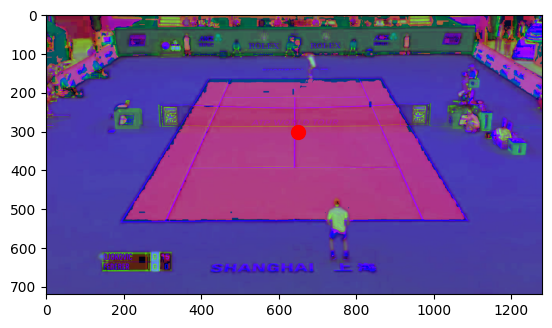

In [27]:
frame= cv2.imread('Dataset/game1/Clip1/0165.jpg')

frame_hsv= cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
#plot image with its center as a bright red dot
plt.imshow(frame_hsv)
plt.scatter(650, 300, c='r', s=100)


In [137]:
frame_hsv.shape

(720, 1280, 3)

In [138]:
center_x= np.int16(np.ceil(frame_hsv.shape[1]/2))
center_y= np.int16(frame_hsv.shape[0]/2)
print(center_x, center_y)

640 360


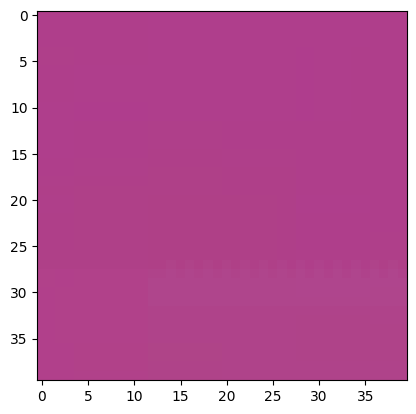

In [139]:
# crop a rectangular window in the center of the frame

cropped = frame_hsv[(center_y-20):(center_y+20), (center_x+20):(center_x+60), :]
plt.imshow(cropped)

In [140]:
#get the predominant color from the rectangular region
h, s, v = cv2.split(cropped)
hist_h = cv2.calcHist([h], [0], None, [180], [0, 180])
hist_s = cv2.calcHist([s], [0], None, [256], [0, 256])
hist_v = cv2.calcHist([v], [0], None, [256], [0, 256])

    # Find peaks in the histograms
peaks_h = np.argsort(-hist_h.flatten())[:1]
peaks_s = np.argsort(-hist_s.flatten())[:1]
peaks_v = np.argsort(-hist_v.flatten())[:1]

for peak_h, peak_s, peak_v in zip(peaks_h, peaks_s, peaks_v):
    hue = int(peak_h * 180 / 256)
    saturation = int(peak_s)
    value = int(peak_v)
    predominant_color_hsv=(hue, saturation, value)

In [141]:
predominant_color_hsv

(123, 62, 140)

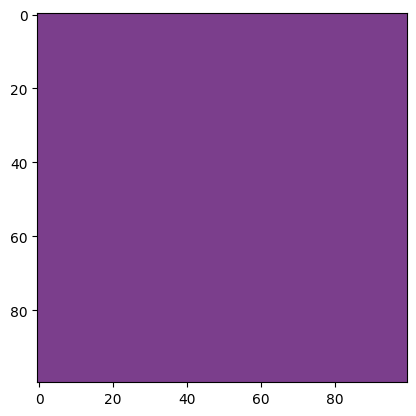

In [142]:
square_size = 100
square_image = np.ones((square_size, square_size, 3), dtype=np.uint8) * predominant_color_hsv

    # Plot the square
plt.imshow(square_image)

In [143]:
threshold_range = 10
lower_bound = np.array([predominant_color_hsv[0] -20, 50, 50])
upper_bound = np.array([predominant_color_hsv[0] + 60, 255, 255])

    # Create a binary mask by thresholding the HSV image
mask = cv2.inRange(frame_hsv, lower_bound, upper_bound)

In [144]:
lower_bound

array([103,  50,  50])

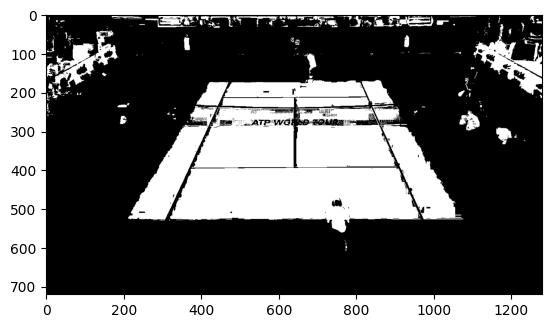

In [145]:
plt.imshow(mask, cmap='gray')

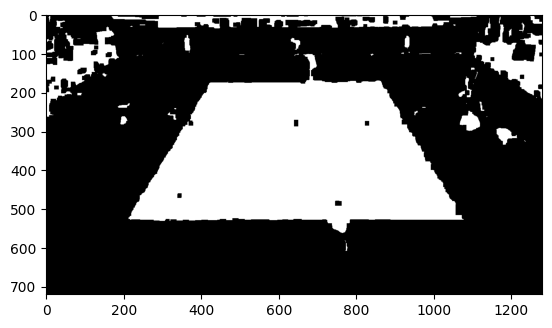

In [146]:
#perform an opening on the mask
kernel = np.ones((10, 10), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

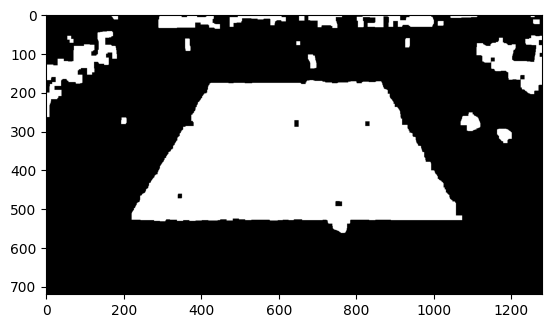

In [147]:
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')

230406.0


TypeError: Image data of dtype object cannot be converted to float

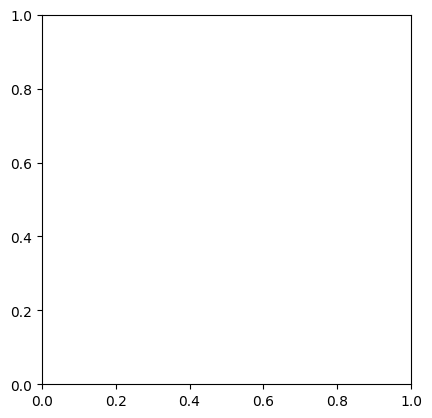

In [148]:
#retriueve external contours
contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#iterate over the contours and filter for arra > 1000
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 100000:
        print(area)
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(frame)

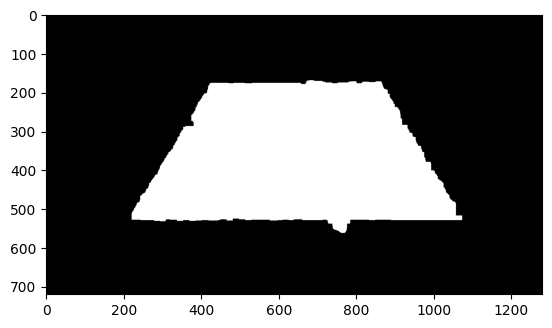

In [40]:
#create a binary image with only the filtered countours
mask = np.zeros_like(opening)
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 100000:
        cv2.drawContours(mask, [contour], -1, 255, -1)
plt.imshow(mask, cmap='gray')

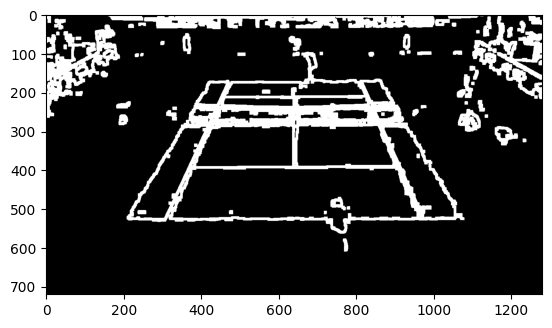

In [149]:
edges = cv2.Canny(mask,200,400)
plt.imshow(edges, cmap='gray')
#dilate the edges
kernel = np.ones((7, 7), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)
plt.imshow(dilated, cmap='gray')

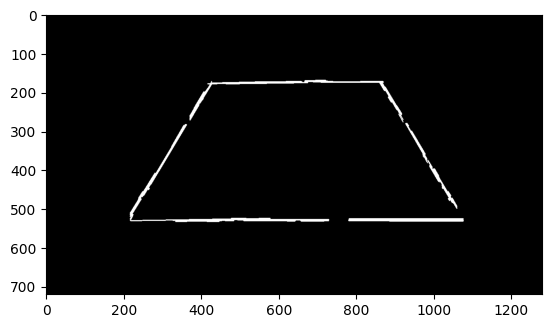

In [42]:
rho, theta, thresh = 2, np.pi/180, 400
lines = cv2.HoughLinesP(dilated, rho, theta, thresh)
# Draw detected lines on the original image
line_mask = np.zeros_like(dilated)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_mask, (x1, y1), (x2, y2), (255), 2)
plt.imshow(line_mask, cmap='gray')

In [43]:
def extract_angles(lines):
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1)
        angles.append(angle)
    return angles

In [44]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = extract_angles(lines)
    #print(angles)
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*np.abs(angle)), np.sin(2*np.abs(angle))]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    pts_dict = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
        pts_dict[labels[i]].append(pts[i])
    segmented = list(segmented.values())
    pts_dict = list(pts_dict.values())
    return segmented,pts_dict

In [45]:
segmented, pts = segment_by_angle_kmeans(lines)


In [46]:
segmented[0][0]

array([[494, 529, 729, 529]], dtype=int32)

In [47]:
def plot_lines(lines):
    """Plot line segments"""
    for line in lines[0]:
        x1, y1, x2, y2 = line[0]
        plt.plot([x1, x2], [y1, y2], 'r')
    for line in lines[1]:
        x1, y1, x2, y2 = line[0]
        plt.plot([x1, x2], [y1, y2], 'b')

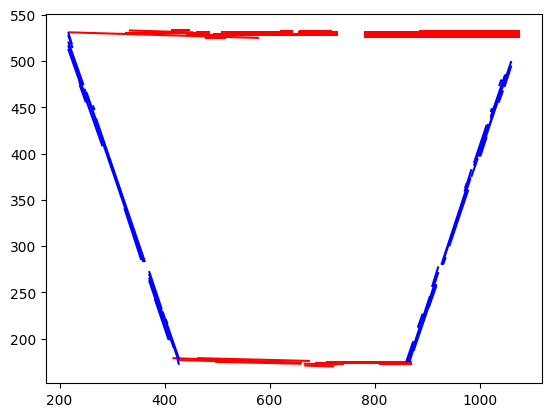

In [48]:
plt.figure()
plot_lines(segmented)
plt.show()

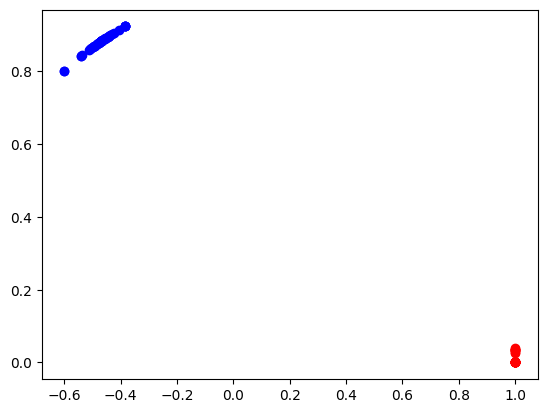

In [49]:
#scatter plot pts
red= pts[0]
blue= pts[1]
plt.figure()
plt.scatter(*zip(*red), color='r')
plt.scatter(*zip(*blue), color='b')

In [50]:
segmented[0][0]

array([[494, 529, 729, 529]], dtype=int32)

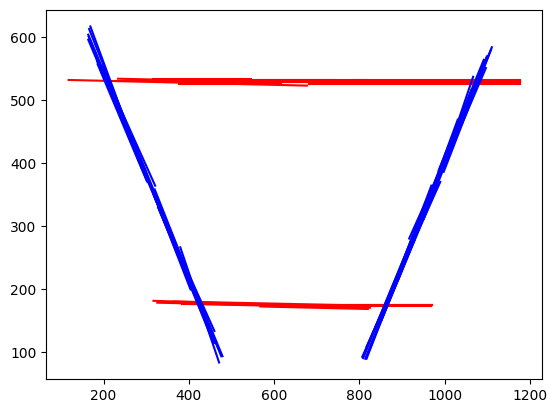

In [83]:
#elongate every line segment in blue and red array and plot them again
# lenAB = sqrt(pow(A.x - B.x, 2.0) + pow(A.y - B.y, 2.0));
# C.x = B.x + (B.x - A.x) / lenAB * length;
# C.y = B.y + (B.y - A.y) / lenAB * length
def elongate_lines(lines, distance=100):
    """Elongate line segments"""
    elongated_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
    
        diff = np.sqrt(pow(x1 - x2, 2.0) + pow(y1 - y2, 2.0))
        x1_new = int(x2 + (x2-x1)/diff * distance)
        y1_new = int(y2 + (y2-y1)/diff * distance)
        x2_new = int(x1 - (x2-x1)/diff * distance)
        y2_new = int(y1 - (y2-y1)/diff * distance)
        elongated_lines.append([[x2_new, y2_new, x1_new, y1_new]])
    return elongated_lines
elonated_red = elongate_lines(segmented[0])
elonated_blue = elongate_lines(segmented[1])
plt.figure()
plot_lines([elonated_red, elonated_blue])
plt.show()

In [85]:
def intersect_lines(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    
    # Denominator for ua and ub are the same, so store this calculation
    denominator = (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)

    # Make sure the denominator is not zero
    if denominator == 0:
        return None

    # Calculate the ua and ub values
    ua = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / denominator
    ub = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / denominator

    # If the ua and ub values are between 0 and 1, the lines are intersecting
    if 0 <= ua <= 1 and 0 <= ub <= 1:
        # Calculate intersection point
        intersection_x = x1 + ua * (x2 - x1)
        intersection_y = y1 + ua * (y2 - y1)
        return intersection_x, intersection_y
    else:
        return None

In [90]:
intersections = []
for red_line in elonated_red:
    for blue_line in elonated_blue:
        intersection = intersect_lines(red_line, blue_line)
        if intersection is not None:
            intersections.append(intersection)

In [87]:
intersections

[(1078.0404411764705, 529.0),
 (1075.9259259259259, 529.0),
 (1070.9204545454545, 529.0),
 (1063.022099447514, 529.0),
 (1074.8878504672898, 529.0),
 (1079.819587628866, 529.0),
 (1083.0666666666666, 529.0),
 (1077.3682170542636, 529.0),
 (1079.8382352941176, 532.0),
 (1077.7314814814815, 532.0),
 (1072.7272727272727, 532.0),
 (1064.513812154696, 532.0),
 (1076.696261682243, 532.0),
 (1081.5360824742268, 532.0),
 (1084.9666666666667, 532.0),
 (1079.1705426356589, 532.0),
 (859.4782608695652, 175.0),
 (861.1497326203208, 175.0),
 (860.1780104712042, 175.0),
 (866.680412371134, 175.0),
 (866.0970149253731, 175.0),
 (866.9791666666667, 175.0),
 (864.323076923077, 175.0),
 (866.9351851851852, 175.0),
 (861.535294117647, 175.0),
 (864.1074380165289, 175.0),
 (1076.8419117647059, 527.0),
 (1074.7222222222222, 527.0),
 (1069.715909090909, 527.0),
 (1062.0276243093922, 527.0),
 (1073.6822429906542, 527.0),
 (1078.6752577319587, 527.0),
 (1081.8, 527.0),
 (1076.1666666666665, 527.0),
 (204.6313

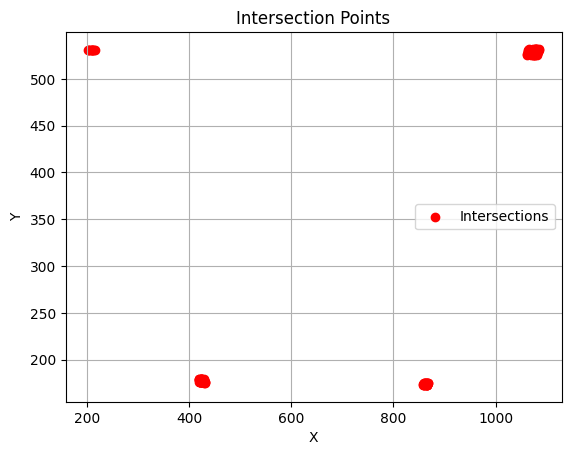

In [88]:
intersections = np.array(intersections)
intersection_x = intersections[:, 0]
intersection_y = intersections[:, 1]

# Plot the intersection points
plt.scatter(intersection_x, intersection_y, color='red', label='Intersections')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Intersection Points')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
# Convert intersection points to numpy array
intersections = np.array(intersections, dtype=np.float32)

# Ensure that the data is reshaped correctly for k-means clustering
intersections = intersections.reshape(-1, 2)

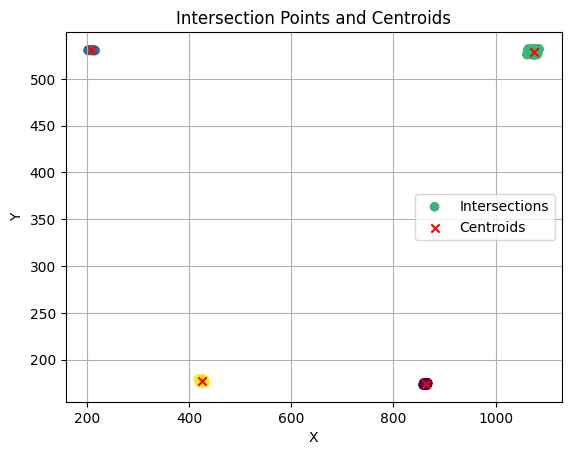

In [92]:
# Perform k-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4  # Number of clusters
_, labels, centroids = cv2.kmeans(intersections, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Plot the intersection points
plt.scatter(intersections[:,0], intersections[:,1], c=labels.flatten(), cmap='viridis', marker='o', label='Intersections')
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x', label='Centroids')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Intersection Points and Centroids')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
print(centroids)
# 0, 2, 1, 3


[[ 863.1404   174.00002]
 [ 209.07451  530.5337 ]
 [1075.4796   529.1667 ]
 [ 424.8101   177.15419]]


In [94]:
centroids = centroids[np.argsort(centroids[:, 0])]

# Connect centroids with lines
lines = np.concatenate([centroids, np.roll(centroids, -1, axis=0)], axis=1)

In [95]:
for line in lines:
    pt1 = (int(line[0]), int(line[1]))
    pt2 = (int(line[2]), int(line[3]))
    cv2.line(frame, pt1, pt2, (0, 0, 255), 2)

In [103]:
for centroid in centroids:
    center = (int(centroid[0]), int(centroid[1]))
    cv2.circle(frame, center, 5, (0, 255, 0), -1)

# Display the image with lines and centroids
cv2.imshow("Image with Lines and Centroids", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()